In [1]:
%matplotlib inline
import gepetuto.magic

# Solving QPs

In [ ]:
import numpy as np
import numpy.linalg as npla
import matplotlib.pyplot as plt

from utils.random_qp import (
    generate_convex_eqp,
    generate_convex_qp_nolicq,
    infNorm,
    QP)


In this tutorial, we will be studying the resolution of equality-constrained quadratic programs (EQPs), which take the general form
\begin{align}
  &\min_x \frac{1}{2}x^\top Q x + q^\top x \\
  &\text{s.t.}\ Ax + b = 0.
\end{align}

This is the simplest form of quadratic program (QP), as it does *not* include inequality constraints, which are very difficult to handle in general.

## 1. Inverting KKT matrices

### Some assembly required

We will generate a random, convex equality-QP, and assemble its KKT matrix
$$
  \mathcal{K} = \begin{bmatrix}
  Q & A^\top \\ A & 
  \end{bmatrix}
$$
to solve it directly.

In [4]:
# %load tp1/generated/qp_kkt_get_a_qp
nx = 3
nc = 1

qp = generate_convex_eqp(nx,nx,nc)


Now, assemble the KKT matrix and solve the QP.

In [6]:
%do_not_load_snippet tp1/generated/qp_kkt_assemble_kkt

In [13]:
# %load tp1/generated/qp_kkt_assemble_kkt
# Assemble the KKT matrix 
K = np.block([ [qp.Q, qp.A.T], [qp.A, np.zeros([nc,nc]) ]])
# Assemble the corresponding vector
k = np.concatenate([ -qp.q, -qp.b ])

# Solve the QP by inverting the QP
primal_dual = npla.inv(K) @ k
# Extact primal and dual optimal from the KKT inversion
x_opt = primal_dual[:nx]
mult_opt = primal_dual[nx:]


Print the corresponding primal and dual residuals (use the `infNorm` function)
$$
  p_\text{err} = \| Ax - b \|_\infty, \quad
  d_\text{err} = \| Qx + q + A^\top y \|_\infty.
$$

Is the problem solved?

In [15]:
# %load tp1/generated/qp_kkt_pd_err
perr = infNorm(qp.A @ x_opt + qp.b)
derr = infNorm(qp.Q @ x_opt + qp.q + qp.A.T @ mult_opt)
print("Primal error:", perr)
print("Dual   error:", derr)


### Solving bad QPs

In this second part, we will randomly generate some QPs that go from very nice (strictly convex) to terrible (redundant constraints, etc.).

First, rewrite your code for inverting the KKT matrix as a function:

In [19]:
# %load tp1/generated/qp_kkt_kkt
def solve_qp_inv_kkt(qp: QP):
    """Routine to solve a QP from its KKT matrix.

    Must return: primal solution, dual solution,
    primal and dual residual.
    """
    ...


In [20]:
# %load tp1/generated/qp_kkt_kkt_solution
def solve_qp_inv_kkt(qp: QP):
    Q = qp.Q
    q = qp.q
    A = qp.A
    b = qp.b
    nx = Q.shape[0]
    nc = b.shape[0]
    mat = np.block([[Q, A.T], [A, np.zeros((nc, nc))]])
    rhs = np.concatenate([q, b])

    matinv = npla.inv(mat)
    pd_opt = -matinv @ rhs
    xopt, yopt = pd_opt[:nx], pd_opt[nx:]
    derr = infNorm(Q @ xopt + q + A.T @ yopt)
    perr = infNorm(A @ xopt + b)
    return xopt, yopt, perr, derr


Now we're going to generate a few couple of QPs:

In [21]:
# %load tp1/generated/qp_kkt_get_some_qps
qp1_strict = generate_convex_eqp(4, 4, 2, check_strictly_convex=True)
qp2_nostrict = generate_convex_eqp(4, 2, 2)
qp3_nolicq = generate_convex_qp_nolicq(4, 2, 2, 1)
qp4_strict_nolicq = generate_convex_qp_nolicq(4, 5, 2, 1)
qp5_overconstrained = generate_convex_eqp(4, 5, 5)


Read the help for some of the functions:

In [22]:
help(generate_convex_eqp)

Look at the KKT matrices of these QPs. What's wrong with each of them?

**Hint** Try using `npla.eigvalsh` to get their eigenvalues. Also look at the eigenvalues of the matrix $Q$.

Now run the following cell: it will attempt solving each QP and print the resulting primal-dual errors.

Customize the output how you want. The try/except statement might be triggered at some point...
1. what kind of error do we get?
2. for which QPs?

In [24]:
# %load tp1/generated/qp_kkt_solve_some_qps
for qp in [
    qp1_strict,
    qp2_nostrict,
    qp3_nolicq,
    qp4_strict_nolicq,
    qp5_overconstrained,
]:
    try:
        print("====")
        xopt, yopt, perr, derr = solve_qp_inv_kkt(qp)
        print("primal error = {}".format(perr))
        print("dual   error = {}".format(derr))
    except Exception as e:
        print("Got an exception: {}".format(e))


**Bonus question** Instead of solving
$$
  \begin{bmatrix}
  Q & A^\top \\ A 
  \end{bmatrix}
  \begin{bmatrix}
    x \\ y
  \end{bmatrix}
  = -\begin{bmatrix} q \\ b \end{bmatrix}
$$
try, for $Q$ positive definite, solving a system in $y$ with the matrix $AQ^{-1}A^\top$.

1. Write the full system (with its right-hand side) and how to get $x$ back from $y$
2. Write the code below, and test it out: is it more or less accurate than straight KKT?

In [15]:
def goldfarb_method(qp: QP):
    """Returns the same outputs as the previous methods."""
    ...

### Proximal iteration

Following the slides, write down the code for a *single* iteration of the proximal EQP algorithm: 

In [25]:
# %load tp1/generated/qp_prox_prox_iteration
def solve_qp_prox_one_iter(qp: QP, prev_l, mu: float = 0.01):
    """Perform one iteration of the proximal algo.
    
    This should return the same outputs as `solve_qp_inv_kkt`.
    """
    ...


In [26]:
# %load tp1/generated/qp_prox_prox_iteration_sol
def solve_qp_prox_one_iter(qp: QP, prev_l, mu: float = 0.01):
    """Perform one iteration of the proximal algo.
    
    This should return the same outputs as `solve_qp_inv_kkt`.
    """
    Q = qp.Q
    q = qp.q
    A = qp.A
    b = qp.b + mu * prev_l
    nx = Q.shape[0]
    nc = b.shape[0]
    mat = np.block([[Q, A.T], [A, -mu * np.eye(nc)]])
    rhs = np.concatenate([q, b])

    matinv = npla.inv(mat)
    pd_opt = -matinv @ rhs
    xopt, lopt = pd_opt[:nx], pd_opt[nx:]
    derr = infNorm(Q @ xopt + qp.q + A.T @ lopt)
    perr = infNorm(A @ xopt + qp.b)
    return xopt, lopt, perr, derr


Run the algorithm for one iteration on a QP (it can be one of the previous ones, or some other QP you write down by hand or generate):

In [27]:
# %load tp1/generated/qp_prox_iterate_once
test_qp = generate_convex_eqp(5, 4, 4)
yinit = np.zeros(4)
solve_qp_prox_one_iter(test_qp, yinit)


Now iterate a few times:

In [35]:
# %load tp1/generated/qp_prox_iterate_manual
numiters = 30
yi = yinit
errs_ = []

for t in range(numiters):
    xi, yi, perr, derr = solve_qp_prox_one_iter(test_qp, yi, mu=0.1)  # play with mu?
    errs_.append((perr, derr))
    print(errs_[-1])


Now, let's plot the convergence of the method using the values of the primal and dual residuals stored in `errs_`.

In [57]:
# %load tp1/generated/qp_prox_plot_conv
errs_ = np.asarray(errs_)
plt.subplot(121)
# primal error
plt.plot(errs_[:, 0], ls="--")
plt.yscale("log")
plt.title("Primal error $\| Ax - b \|$")

plt.subplot(122)
plt.plot(errs_[:, 1], ls="--")
plt.yscale("log")
plt.title("Dual error $\| Qx + q + A^\\top y \|$")
plt.tight_layout()


Go back to the manual iteration and play with the parameter $\mu$, then plot the convergence again. What do you see?

### Code your own solver, with automatic stopping

Now, we will rewrite the procedure as a self-contained function which will stop automatically once the primal and dual errors are below a prescribed threshold $\epsilon$:
$$
  \max(p_\text{err}, d_\text{err}) \leq \epsilon.
$$

The method:
1. should reuse the code from before, solving one iteration
2. should stop if and only if it has converged **or** reached a max number of iterations $M$

In [41]:
# %load tp1/generated/qp_prox_auto_iteration
def solve_qp_prox(qp: QP, yinit, mu: float = 0.01, epsilon=1e-12, max_iters=200):
    """Iterate the proximal algorithm until you have converged to a desired threshold :math:`epsilon`.

    Parameters
        qp: QP instance
        yinit: initial-guess for the dual variables
        mu: proximal parameter
        epsilon: threshold
        max_iters: maximum number of iterations

    This should return the same outputs as `solve_qp_inv_kkt`."""
    ...


In [45]:
# %load tp1/generated/qp_prox_auto_iteration_sol
def solve_qp_prox(qp: QP, yinit, mu: float = 0.01, epsilon=1e-12, max_iters=200):
    yi = yinit.copy()
    for t in range(max_iters):
        xi, yi, perr, derr = solve_qp_prox_one_iter(qp, yi, mu)
        conv = max(perr, derr) <= epsilon
        if conv:
            break
    return xi, yi, perr, derr


Now, we shall get some weird QPs, and attempt to solve them again.

In [49]:
# %load tp1/generated/qp_prox_get_some_qps
qp1_strict = generate_convex_eqp(4, 4, 2, check_strictly_convex=True)
qp2_nostrict = generate_convex_eqp(4, 2, 2)
qp3_nolicq = generate_convex_qp_nolicq(4, 2, 2, 1)
qp4_strict_nolicq = generate_convex_qp_nolicq(4, 5, 2, 1)
qp5_overconstrained = generate_convex_eqp(4, 5, 5)

mu = 1e-5

for qp in [
    qp1_strict,
    qp2_nostrict,
    qp3_nolicq,
    qp4_strict_nolicq,
    qp5_overconstrained,
]:
    print("====")    
    xopt, yopt, perr, derr = solve_qp_prox(qp, yinit=np.zeros(qp.b.size), mu=mu)
    print("primal error = {}".format(perr))
    print("dual   error = {}".format(derr))


### Plotting the influence of $\mu$

1. Rewrite the `solve_qp_prox` function from before to return the *sequence* of all primal-dual errors during the resolution of the QP.
2. Choose a QP instance, and for this instance solve it using multiple values of $\mu$ and plot the convergence diagram

In [61]:
# %load tp1/generated/qp_prox_auto_iteration_sol_diag
def solve_qp_prox(qp: QP, yinit, mu: float = 0.01, epsilon=1e-12, max_iters=200):
    yi = yinit.copy()
    perrs = []
    derrs = []
    for t in range(max_iters):
        xi, yi, _perr, _derr = solve_qp_prox_one_iter(qp, yi, mu)
        conv = max(_perr, _derr) <= epsilon
        perrs.append(_perr)
        derrs.append(_derr)
        if conv:
            break
    return xi, yi, perrs, derrs


In [73]:
# %load tp1/generated/qp_prox_solver_mu_impact
qp = qp1_strict
mu_vals = [0.1, 0.01, 1e-4, 1e-6]
epsilon = 1e-14

plt.subplot(111)
for mu in mu_vals:
    _, _, perrs, derrs = solve_qp_prox(qp, np.zeros(qp.b.size), mu, epsilon=epsilon)
    perrs = np.asarray(perrs)
    plt.plot(perrs, label="$\\mu = {:.2e}$".format(mu), ls='--')

plt.yscale("log")
plt.legend()
plt.tight_layout()


## 3. Some QPs from robotics

### Inverse dynamics on Digit:

In [100]:
from utils.robotics_qp import load_digit_dyn_qp, load_crocoddyl_qp
from matplotlib.ticker import MaxNLocator

In [101]:
digit_qp = load_digit_dyn_qp()

In [102]:
yopt = np.zeros(digit_qp.b.size)
xopt, yopt, perr, derr = solve_qp_prox(digit_qp, yopt)

Text(0.5, 1.0, 'Primal error - inverse dynamics on Digit')

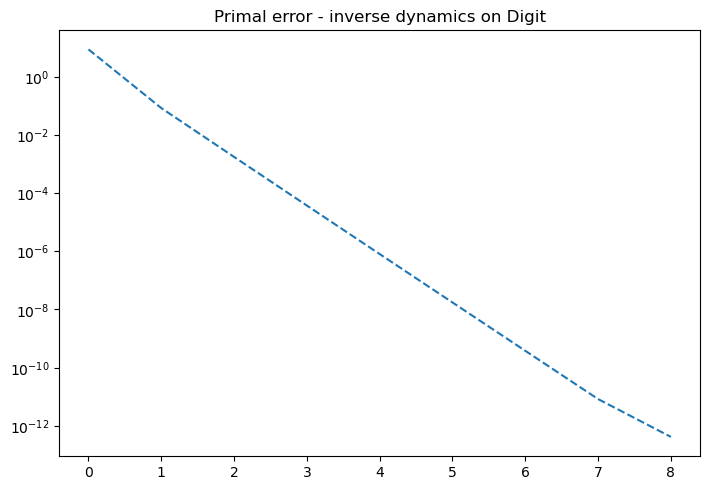

In [105]:
ax = plt.axes()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(perr, ls="--")
plt.yscale("log")
plt.tight_layout()
plt.title("Primal error - inverse dynamics on Digit")

### Control QP

This is a QP from Crocoddyl, which will have slow computation:

In [106]:
croc_qp = load_crocoddyl_qp()
yinit = np.zeros(croc_qp.b.size)
mu = 1e-6
xopt, yopt, perr, derr = solve_qp_prox(croc_qp, yinit, mu=mu)

Text(0.5, 1.0, 'Primal error - QP from Crocoddyl')

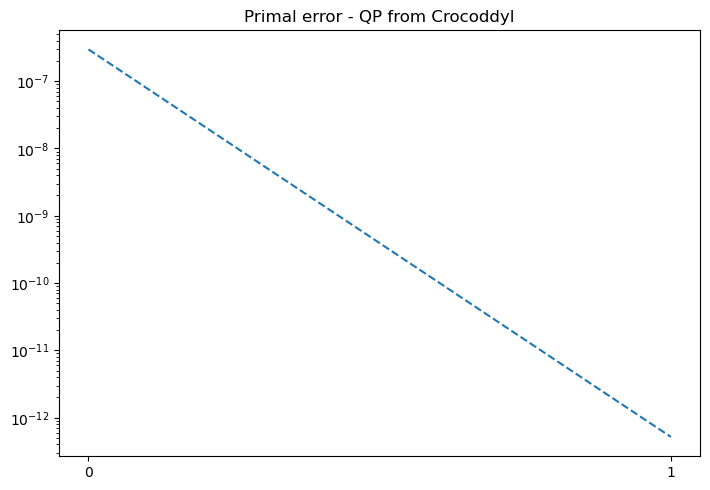

In [108]:
plt.figure()
ax = plt.axes()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(perr, ls="--")
ax.set_yscale("log")
plt.tight_layout()
plt.title("Primal error - QP from Crocoddyl")